## 自然语言处理 Nature Language Processing

- 传统NLP
    - 命名实体抽取
    - 词性标注
    - 中文分词 (jieba)
    - 文本挖掘 (关键词提取 TF-IDF)
    - .......
- 现代NLP (神经网络)
    - 文本情感分析 Sentiment Analysis
    - 神经机器翻译 NMT
    - 大语言模型 LLM
    - ......
    
- word2vec (Skip-Gram / CBOW)
    - nn.Embedding (Token -> Vector)
    - nn.Linear (Vector -> Classification -> Token)

### 文本数据预处理

In [24]:
class Vocab:
    """ 用于存储单词词元的词典类 """
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []
        
    def add(self, word):
        """ 用于向词典中添加新的单词 """
        if word not in self.idx2word:
            self.word2idx[word] = len(self.idx2word)
            self.idx2word.append(word)
            
    def __len__(self):
        """ 用于返回该词典的长度 """
        return len(self.idx2word)

In [27]:
import pandas as pd

df_reviews = pd.read_csv("../data/Amazon-Product-Reviews - Amazon Product Review.csv")[["review_body", "sentiment"]]
df_reviews = df_reviews.head(100) # ToDo: 使用全量数据
df_reviews

,review_body,sentiment
0,Great love it,1
1,Lots of ads<br />Slow processing speed<br />Oc...,0
2,Excellent unit. The versatility of this table...,1
3,I bought this on Amazon Prime so I ended up bu...,1
4,All Amazon products continue to meet my expect...,1
...,...,...
95,Excellent,1
96,Love the upgrade.,1
97,It was a birthday gift and I love it,1
98,My 8 and 7 year old love their tablets!,1


In [35]:
from typing import List

def text_preprocessing(doc: str)->List[str]:
    """ 文本预处理函数 """
    stop_words = ["(", ")", ",", ".", "?", "!", "=", "<", ">", "[", "]", ""]
    doc = doc.replace("<br />", " ")
    return [item.lower() for item in doc.strip().split(" ") if item not in stop_words]

In [37]:
vocab = Vocab()

for idx, row in df_reviews.iterrows():
    for word in text_preprocessing(row.review_body):
        vocab.add(word)

In [42]:
len(vocab)

984

###  嵌入层 Embedding

In [ ]:
# word (tokenize)-> [0, 1, 2] (vectorize)-> array -> tensor -> model -> output
# word2vec: 

In [54]:
import torch
import torch.nn as nn

class Embedding(nn.Module):
    """ 嵌入层 """
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.fc = nn.Linear(vocab_size, embedding_size)
        
    def forward(self, token):
        """ 前向传播方法 """
        # x: 16 -> [vocab_size] -> [embedding_size]
        one_hot = torch.zeros(self.vocab_size)
        one_hot[token] = 1
        return self.fc(one_hot)

In [55]:
model = Embedding(len(vocab), 16)
model(20)

tensor([ 0.0004, -0.0230,  0.0348, -0.0200,  0.0508,  0.0361,  0.0287,  0.0060,
         0.0096, -0.0206, -0.0116,  0.0472,  0.0054,  0.0065,  0.0576, -0.0004],
       grad_fn=<AddBackward0>)

###  Word2Vec [Skip-Gram] 词向量模型

- target (中心词)
- context (上下文)

In [78]:
class Word2Vec(nn.Module):
    """ 词向量模型 """
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.fc = nn.Linear(embedding_size, vocab_size)
    
    def forward(self, x):
        embedded = self.embeddings(x)  # [batch_size, embedding_size]
        return self.fc(embedded)       # [batch_size, vocab_size]
    
model = Word2Vec(len(vocab), 16)

In [65]:
df_reviews.review_body.values[1]

'Lots of ads<br />Slow processing speed<br />Occasionally shuts down apps<br />WIFI keeps having authentication issues<br /><br />Was cheap for a tablet and now i know why.'

In [98]:
def skipgram_data(words: List[str], window_size: int=1):
    """ 创建 Skip-Gram模型训练数据 """
    data = []
    for i, target_word in enumerate(words):
        for j in range(max(0, i-window_size), min(len(words), i+window_size+1)):
            if j != i:
                context_word = words[j]
                data.append((vocab.word2idx.get(target_word), vocab.word2idx.get(context_word)))
    return data
                
line = text_preprocessing(df_reviews.review_body.values[1])
skipgram_data(line, 1)

[(3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (8, 9),
 (9, 8),
 (9, 10),
 (10, 9),
 (10, 11),
 (11, 10),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (17, 18),
 (18, 17),
 (18, 19),
 (19, 18),
 (19, 20),
 (20, 19),
 (20, 21),
 (21, 20),
 (21, 22),
 (22, 21),
 (22, 23),
 (23, 22),
 (23, 24),
 (24, 23),
 (24, 25),
 (25, 24),
 (25, 26),
 (26, 25),
 (26, 27),
 (27, 26)]

In [100]:
from torch.utils.data import Dataset, DataLoader

class SkipGramDataset(Dataset):
    """ SkipGram 模型数据集 """
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        target = self.data[idx][0]
        context = self.data[idx][1]
        return torch.tensor(target, dtype=torch.long), torch.tensor(context, dtype=torch.long)
    
data = skipgram_data(line, 1) # ToDo: 使用全量数据
dataset = SkipGramDataset(data)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [110]:
next(iter(dataloader))

[tensor([20, 14, 24,  6]), tensor([21, 13, 25,  7])]

In [112]:
def train_model(model, dataloader, loss_func, optimizer):
    """ 模型训练函数 """
    model.train()
    total_loss = 0.
    for target, context in dataloader:
        context_hat = model(target)
        loss = loss_func(context_hat, context)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [117]:
model = Word2Vec(len(vocab), 16)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [120]:
n_epoch = 500

train_loss = []
for i in range(n_epoch):
    loss = train_model(model, dataloader, loss_func, optimizer)
    train_loss.append(loss)
    print(f"Epoch {i+1} loss: {round(loss, 4)}")

Epoch 1 loss: 1.4154
Epoch 2 loss: 1.4017
Epoch 3 loss: 1.3851
Epoch 4 loss: 1.3734
Epoch 5 loss: 1.3588
Epoch 6 loss: 1.3448
Epoch 7 loss: 1.3328
Epoch 8 loss: 1.319
Epoch 9 loss: 1.3065
Epoch 10 loss: 1.2956
Epoch 11 loss: 1.2816
Epoch 12 loss: 1.27
Epoch 13 loss: 1.2585
Epoch 14 loss: 1.249
Epoch 15 loss: 1.2391
Epoch 16 loss: 1.226
Epoch 17 loss: 1.2169
Epoch 18 loss: 1.2051
Epoch 19 loss: 1.196
Epoch 20 loss: 1.1865
Epoch 21 loss: 1.1775
Epoch 22 loss: 1.1689
Epoch 23 loss: 1.1599
Epoch 24 loss: 1.151
Epoch 25 loss: 1.1426
Epoch 26 loss: 1.1344
Epoch 27 loss: 1.1272
Epoch 28 loss: 1.1178
Epoch 29 loss: 1.1105
Epoch 30 loss: 1.1018
Epoch 31 loss: 1.0954
Epoch 32 loss: 1.0871
Epoch 33 loss: 1.0789
Epoch 34 loss: 1.0738
Epoch 35 loss: 1.0663
Epoch 36 loss: 1.06
Epoch 37 loss: 1.0547
Epoch 38 loss: 1.0468
Epoch 39 loss: 1.0404
Epoch 40 loss: 1.0356
Epoch 41 loss: 1.0292
Epoch 42 loss: 1.0231
Epoch 43 loss: 1.0184
Epoch 44 loss: 1.0105
Epoch 45 loss: 1.0077
Epoch 46 loss: 1.0017
Epoch 

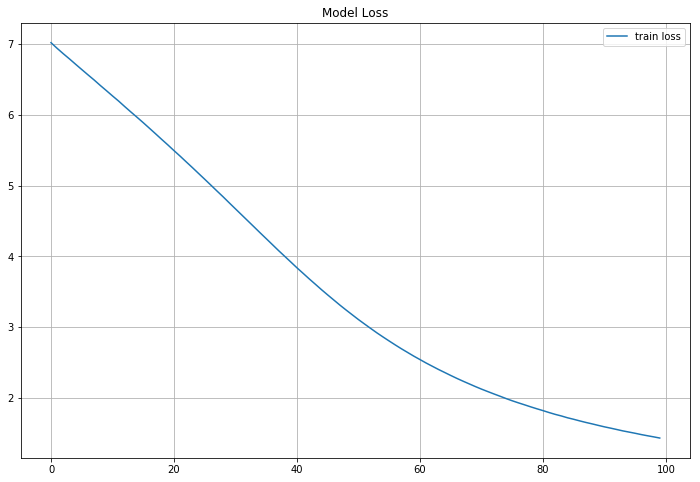

In [119]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label="train loss")
plt.title("Model Loss")
plt.grid()
plt.legend()
plt.show()